# Tech Challenge - Análise de Atrasos de Voos

**O problema** </br>
O transporte aéreo é uma parte vital da infraestrutura global, mas os 
atrasos de voos impactam milhões de passageiros todos os anos. Neste projeto, 
você utilizará o conjunto de dados público que contém informações detalhadas 
sobre voos nos EUA para desenvolver análises e modelos preditivos e/ou 
exploratórios aplicando técnicas de Machine Learning supervisionado e não 
supervisionado. 

**Objetivos do Projeto** </br>
Aplicar o conhecimento adquirido sobre modelagem supervisionada e não 
supervisionada e desenvolver um pipeline completo de ciência de dados, desde 
a exploração dos dados até a interpretação dos resultados. 

## Exploração dos dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar os dados dos arquivos CSV
flights_df = pd.read_csv('flights.csv')
airlines_df = pd.read_csv('airlines.csv')
airports_df = pd.read_csv('airports.csv')

C:\Users\Carol\AppData\Local\Temp\ipykernel_19936\2754484279.py:6: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_df = pd.read_csv('flights.csv')


Inicialmente, vamos observar apenas as primeiras linhas do nosso dataframe, selecionando apenas algumas colunas relevantes sobre atrasos. Com elas já conseguimos extrair algumas informações importantes.

In [2]:
# Copiando o dataframe principal e exibindo as primeiras linhas
df_convert_time_delay = flights_df.copy()[:10]

# Função para formatar horas no formato HHMM para HH:MM para melhor visualização
def format_heure(heure):
    if pd.isna(heure):
        return None
    heure_str = str(int(heure)).zfill(4)
    return f"{heure_str[:2]}:{heure_str[2:]}"

df_convert_time_delay['SCHEDULED_DEPARTURE'] = df_convert_time_delay['SCHEDULED_DEPARTURE'].apply(format_heure)
df_convert_time_delay['DEPARTURE_TIME'] = df_convert_time_delay['DEPARTURE_TIME'].apply(format_heure)
df_convert_time_delay['SCHEDULED_ARRIVAL'] = df_convert_time_delay['SCHEDULED_ARRIVAL'].apply(format_heure)
df_convert_time_delay['ARRIVAL_TIME'] = df_convert_time_delay['ARRIVAL_TIME'].apply(format_heure)

cols_relevant = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']

df_convert_time_delay[cols_relevant]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,00:05,23:54,-11.0,04:30,04:08,-22.0
1,00:10,00:02,-8.0,07:50,07:41,-9.0
2,00:20,00:18,-2.0,08:06,08:11,5.0
3,00:20,00:15,-5.0,08:05,07:56,-9.0
4,00:25,00:24,-1.0,03:20,02:59,-21.0
5,00:25,00:20,-5.0,06:02,06:10,8.0
6,00:25,00:19,-6.0,05:26,05:09,-17.0
7,00:30,00:44,14.0,08:03,07:53,-10.0
8,00:30,00:19,-11.0,05:45,05:32,-13.0
9,00:30,00:33,3.0,07:11,06:56,-15.0


### Explicação sobre Valores Negativos e Positivos em ARRIVAL_DELAY e DEPARTURE_DELAY

Após a análise descritiva acima, é importante esclarecer o significado dos valores nas colunas `ARRIVAL_DELAY` e `DEPARTURE_DELAY`:

- **Valores positivos** (maiores que 0): Indicam atrasos. Para `ARRIVAL_DELAY`, o voo chegou atrasado; para `DEPARTURE_DELAY`, o voo partiu atrasado.
- **Valores negativos** (menores que 0): Indicam chegadas ou partidas adiantadas. Para `ARRIVAL_DELAY`, o voo chegou antes do horário programado; para `DEPARTURE_DELAY`, o voo partiu antes do horário programado.
- **Valor zero**: Chegada ou partida exatamente no horário programado.

### Análise e tratamento de valores nulos na coluna ARRIVAL_DELAY
Antes de iniciarmos as análises, vamos analisar também valores nulos na coluna ARRIVAL_DELAY. Onde ARRIVAL_DELAY for nulo, vamos calcular ele através da diferença das colunas SCHEDULED_ARRIVAL e ARRIVAL_TIME, se presentes.

In [3]:
print(f"Quantidade de ARRIVAL_DELAY nulos: {flights_df['ARRIVAL_DELAY'].isnull().sum()}")

# Filtrar linhas onde ARRIVAL_DELAY é nulo e SCHEDULED_ARRIVAL e ARRIVAL_TIME não são nulos
df_filtered = flights_df[
    (flights_df['ARRIVAL_DELAY'].isnull()) &
    (flights_df['SCHEDULED_ARRIVAL'].notnull()) &
    (flights_df['ARRIVAL_TIME'].notnull())
].copy()

print(f"Linhas para calcular ARRIVAL_DELAY: {len(df_filtered)}")

def hhmm_to_minutes(hhmm):
    hhmm = int(hhmm)
    return (hhmm // 100) * 60 + (hhmm % 100)

df_filtered['SCHEDULED_MIN'] = df_filtered['SCHEDULED_ARRIVAL'].apply(hhmm_to_minutes)
df_filtered['ARRIVAL_MIN'] = df_filtered['ARRIVAL_TIME'].apply(hhmm_to_minutes)

# Diferença
df_filtered['ARRIVAL_DELAY'] = df_filtered['ARRIVAL_MIN'] - df_filtered['SCHEDULED_MIN']

# Ajuste para voos que cruzam a meia-noite
df_filtered.loc[
    df_filtered['ARRIVAL_DELAY'] < -720,
    'ARRIVAL_DELAY'
] += 1440

df_filtered[['FLIGHT_NUMBER', 'TAIL_NUMBER', 'ARRIVAL_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']].head(10)

Quantidade de ARRIVAL_DELAY nulos: 105071
Linhas para calcular ARRIVAL_DELAY: 12558


,FLIGHT_NUMBER,TAIL_NUMBER,ARRIVAL_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME
724,716,N944DL,282,1009,1451.0
1455,5237,N712SK,264,1041,1505.0
2218,1966,N685SW,139,1000,1219.0
2526,4555,N12552,182,1017,1319.0
2866,1081,N214WN,128,1135,1343.0
4225,1279,N541AA,338,1300,1838.0
4394,4506,N613SK,88,1225,1353.0
4574,6171,N17159,257,1218,1635.0
4636,4169,N11547,227,1243,1630.0
6422,399,N456UA,254,2105,119.0


In [4]:
# Aplicar os valores calculados de ARRIVAL_DELAY de df_filtered de volta ao flights_df
flights_df.update(df_filtered[['ARRIVAL_DELAY']])

# Verificar se os valores foram aplicados
verify_update_df = flights_df[(flights_df['FLIGHT_NUMBER'] == 716) & (flights_df['TAIL_NUMBER'] == 'N944DL')][['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']]
print(verify_update_df)

     SCHEDULED_ARRIVAL  ARRIVAL_TIME  ARRIVAL_DELAY
724               1009        1451.0          282.0


### Análise de outras colunas com valores nulos

In [5]:
print("\nPercentual de valores nulos por coluna:")
null_percent = (flights_df.isnull().mean() * 100).round(2)
print(null_percent)


Percentual de valores nulos por coluna:
YEAR                    0.00
MONTH                   0.00
DAY                     0.00
DAY_OF_WEEK             0.00
AIRLINE                 0.00
FLIGHT_NUMBER           0.00
TAIL_NUMBER             0.25
ORIGIN_AIRPORT          0.00
DESTINATION_AIRPORT     0.00
SCHEDULED_DEPARTURE     0.00
DEPARTURE_TIME          1.48
DEPARTURE_DELAY         1.48
TAXI_OUT                1.53
WHEELS_OFF              1.53
SCHEDULED_TIME          0.00
ELAPSED_TIME            1.81
AIR_TIME                1.81
DISTANCE                0.00
WHEELS_ON               1.59
TAXI_IN                 1.59
SCHEDULED_ARRIVAL       0.00
ARRIVAL_TIME            1.59
ARRIVAL_DELAY           1.59
DIVERTED                0.00
CANCELLED               0.00
CANCELLATION_REASON    98.46
AIR_SYSTEM_DELAY       81.72
SECURITY_DELAY         81.72
AIRLINE_DELAY          81.72
LATE_AIRCRAFT_DELAY    81.72
WEATHER_DELAY          81.72
dtype: float64


Com base no percentual de valores nulos por coluna, podemos identificar quais dados manter ou descartar para otimizar a análise e modelagem:

- **Colunas com baixos percentuais de nulos (0.25% a 1.81%)**: TAIL_NUMBER (0.25%), DEPARTURE_TIME (1.48%), DEPARTURE_DELAY (1.48%), TAXI_OUT (1.53%), WHEELS_OFF (1.53%), ELAPSED_TIME (1.81%), AIR_TIME (1.81%), WHEELS_ON (1.59%), TAXI_IN (1.59%), ARRIVAL_TIME (1.59%), ARRIVAL_DELAY (1.59%). Esses valores ausentes são relativamente poucos e podem ser imputados (e.g., com médias ou zeros para atrasos) ou tratados com drop de linhas, posteriormente.

- **Colunas com altos percentuais de nulos (>80%)**: CANCELLATION_REASON (98.46%), AIR_SYSTEM_DELAY (81.72%), SECURITY_DELAY (81.72%), AIRLINE_DELAY (81.72%), LATE_AIRCRAFT_DELAY (81.72%), WEATHER_DELAY (81.72%). Esses campos estão majoritariamente vazios. Como representam casos raros ou específicos, podem ser **descartados** para simplificar o dataset, evitando viés e reduzindo dimensionalidade.

Além das colunas com altos percentuais de nulos, também podemos remover outras que não impactam diretamente nos voos atrasados, sendo elas: TAIL_NUMBER, AIR_TIME, DISTANCE, WHEELS_ON.

In [6]:
df = flights_df.copy()

# Remover colunas que não impactam na análise de atrasos
cols_to_drop = ['TAIL_NUMBER', 'AIR_TIME', 'DISTANCE', 'WHEELS_OFF', 
                'WHEELS_ON', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

df = df.drop(columns=cols_to_drop)

#### Porcentagem de voos com atraso na chegada
Aproximadamente 36% dos voos apresentaram atraso na chegada.

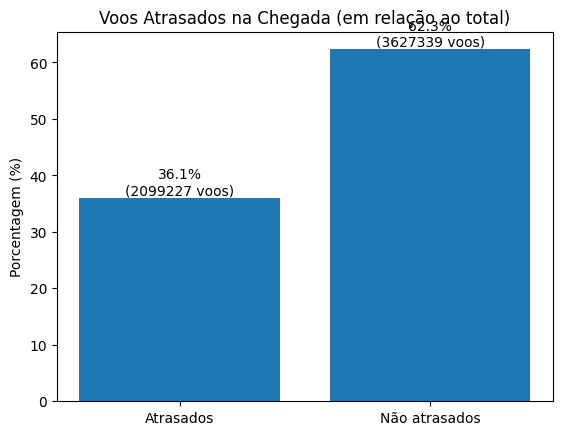

In [7]:
total_voos = len(df)

# Quantidades
qtd_atrasados = np.sum(df["ARRIVAL_DELAY"] > 0)
qtd_no_horario = np.sum(df["ARRIVAL_DELAY"] <= 0)

# Porcentagens (em relação ao total)
percent_atrasados = (qtd_atrasados / total_voos) * 100
percent_no_horario = (qtd_no_horario / total_voos) * 100

# Dados para o gráfico
labels = ["Atrasados", "Não atrasados"]
percentuais = [percent_atrasados, percent_no_horario]
quantidades = [qtd_atrasados, qtd_no_horario]

plt.figure()
bars = plt.bar(labels, percentuais)
plt.ylabel("Porcentagem (%)")
plt.title("Voos Atrasados na Chegada (em relação ao total)")

# Adicionando rótulos (porcentagem + quantidade)
for bar, qtd in zip(bars, quantidades):
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura,
        f"{altura:.1f}%\n({qtd} voos)",
        ha="center",
        va="bottom"
    )

plt.show()


#### Atrasos por companhia aérea

Pesquisar porte desses aeroportos e buscar correlação

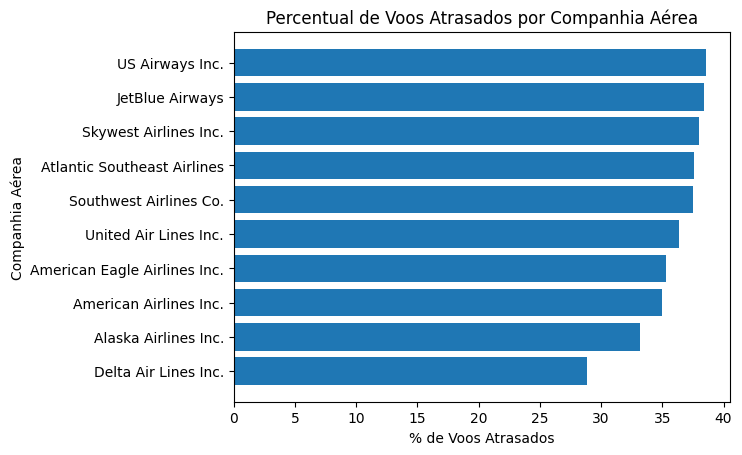

In [8]:
df_merged_airlines = df.merge(
    airlines_df,
    left_on="AIRLINE",
    right_on="IATA_CODE",
    how="left"
)

df_merged_airlines = df_merged_airlines.rename(columns={"AIRLINE_y": "AIRLINE_NAME"})

airline_delay = (
    df_merged_airlines
    .groupby("AIRLINE_NAME")
    .agg(
        total_voos=("FLIGHT_NUMBER", "count"),
        voos_atrasados=("ARRIVAL_DELAY", lambda x: np.sum(x > 0))
    )
)

airline_delay["percent_atrasados"] = (
    airline_delay["voos_atrasados"] / airline_delay["total_voos"] * 100
)

# Filtra companhias com volume relevante
airline_delay = airline_delay[airline_delay["total_voos"] > 10000]

# Ordena
airline_delay = airline_delay.sort_values("percent_atrasados").head(10)

plt.figure()
plt.barh(
    airline_delay.index,
    airline_delay["percent_atrasados"]
)

plt.xlabel("% de Voos Atrasados")
plt.ylabel("Companhia Aérea")
plt.title("Percentual de Voos Atrasados por Companhia Aérea")

plt.show()


#### Percentual de atrasos durante o ano
Observam-se picos nos meses de inverno e durante o verão, períodos que coincidem, respectivamente, com condições climáticas adversas e férias escolares nos Estados Unidos. Meses com menor demanda apresentam percentuais significativamente mais baixos de atraso, indicando impacto direto do volume de passageiros na pontualidade operacional.

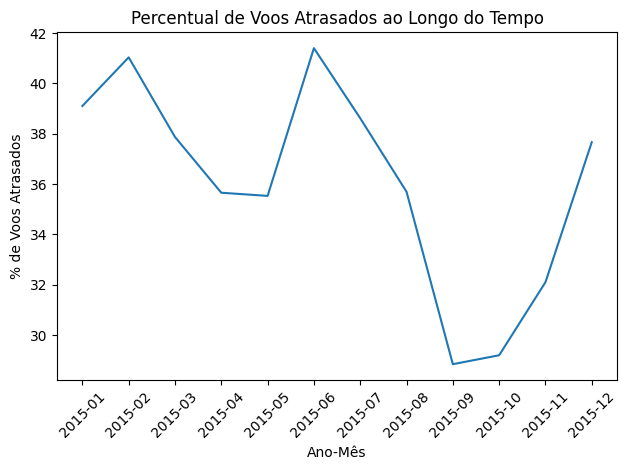

In [9]:
# Agrupamento por ano e mês
delay_time = (
    df
    .groupby(["YEAR", "MONTH"])
    .agg(
        total_voos=("FLIGHT_NUMBER", "count"),
        voos_atrasados=("ARRIVAL_DELAY", lambda x: np.sum(x > 0))
    )
    .reset_index()
)

# Percentual de atraso
delay_time["percent_atrasados"] = (
    delay_time["voos_atrasados"] / delay_time["total_voos"] * 100
)

# Criar eixo temporal contínuo (ótimo para visualização)
delay_time["ANO_MES"] = (
    delay_time["YEAR"].astype(str) + "-" +
    delay_time["MONTH"].astype(str).str.zfill(2)
)

plt.figure()
plt.plot(
    delay_time["ANO_MES"],
    delay_time["percent_atrasados"]
)

plt.xlabel("Ano-Mês")
plt.ylabel("% de Voos Atrasados")
plt.title("Percentual de Voos Atrasados ao Longo do Tempo")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Correlação com atrasos na chegada com atrasos na saída
A elevada (0.92) correlação sugere que o atraso na partida é um forte indicador no atraso na chegada. Isso indica um efeito de cascata operacional, no qual atrasos iniciais impactam diretamente etapas subsequentes do voo.

Pontos acima da reta (y > x) indicam que o voo chegou mais atrasado do que saiu. 
Pontos abaixo da reta (y < x) indicam que o voo recuperou parte do atraso durante a operação.


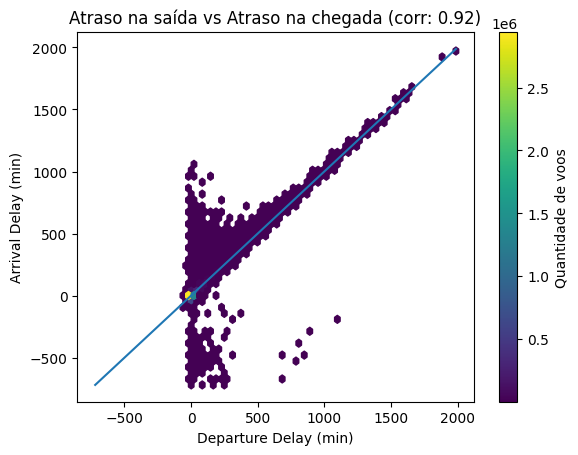

In [ ]:
# Seleciona apenas as colunas necessárias e remove NaNs
df_hex = df[["DEPARTURE_DELAY", "ARRIVAL_DELAY"]].dropna()

x = df_hex["DEPARTURE_DELAY"]
y = df_hex["ARRIVAL_DELAY"]

corr = x.corr(y)

plt.figure()
hb = plt.hexbin(
    x,
    y,
    gridsize=50,      
    mincnt=1         
)

plt.xlabel("Departure Delay (min)")
plt.ylabel("Arrival Delay (min)")
plt.title(f"Atraso na saída vs Atraso na chegada (corr: {corr:.2f})")

# Linha de referência y = x (propagação do atraso)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val]
)

# Barra de cor (densidade)
plt.colorbar(hb, label="Quantidade de voos")

plt.show()

#### Voos Cancelados x Desviados
A análise mostra que menos de 2% dos voos foram cancelados ou desviados. Isso indica que esses eventos são raros no conjunto de dados.

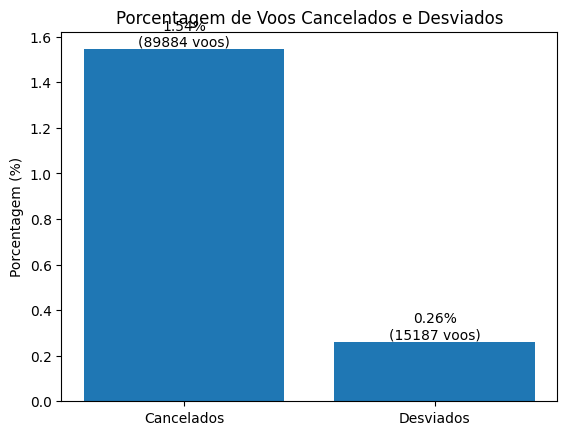

In [10]:
total_voos = len(df)

# Quantidades
qtd_cancelados = np.sum(df["CANCELLED"] == 1)
qtd_desviados = np.sum(df["DIVERTED"] == 1)

# Porcentagens em relação ao total
percent_cancelados = (qtd_cancelados / total_voos) * 100
percent_desviados = (qtd_desviados / total_voos) * 100

plt.figure()
bars = plt.bar(
    ["Cancelados", "Desviados"],
    [percent_cancelados, percent_desviados]
)

plt.ylabel("Porcentagem (%)")
plt.title("Porcentagem de Voos Cancelados e Desviados")

for bar, qtd in zip(bars, [qtd_cancelados, qtd_desviados]):
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura,
        f"{altura:.2f}%\n({qtd} voos)",
        ha="center",
        va="bottom"
    )

plt.show()

#### Distribuição dos Atrasos de Chegada por Mês

O boxplot da distribuição dos atrasos de chegada por mês evidencia um comportamento consistente ao longo do ano. Em todos os meses, a mediana dos atrasos permanece abaixo de zero, indicando que mais da metade dos voos chega no horário ou antecipadamente.

Observa-se que os meses de junho, julho e dezembro apresentam maior dispersão e whiskers superiores mais elevados, sugerindo a ocorrência de atrasos durante períodos de alta demanda, como férias escolares e feriados. Esses meses concentram maior variabilidade operacional, o que está alinhado com o aumento do tráfego aéreo e a maior propagação de atrasos em cascata.

Por outro lado, os meses de setembro e outubro apresentam caixas mais compactas e menor amplitude, indicando maior estabilidade operacional e menor incidência de atrasos extremos. Esse comportamento reforça a hipótese de que períodos de menor demanda favorecem um desempenho mais pontual da malha aérea.

A diferença consistente entre a posição da mediana e a extensão do whisker superior confirma a presença de atrasos extremos, que, embora pouco frequentes, exercem impacto significativo sobre a média mensal.

C:\Users\Carol\AppData\Local\Temp\ipykernel_19936\1869299131.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_month, labels=months, showfliers=False)


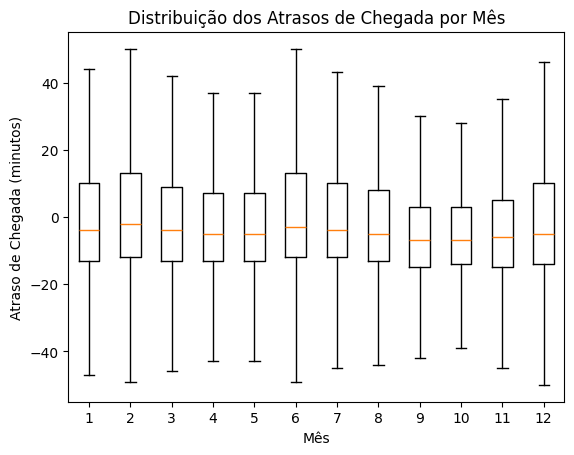

In [ ]:
months = sorted(df['MONTH'].unique())
data_by_month = [
    df[df['MONTH'] == m]['ARRIVAL_DELAY'].dropna()
    for m in months
]

plt.figure()
plt.boxplot(data_by_month, labels=months, showfliers=False)
plt.xlabel("Mês")
plt.ylabel("Atraso de Chegada (minutos)")
plt.title("Distribuição dos Atrasos de Chegada por Mês")
plt.show()

#### Medidas de posição

In [21]:
positive_delays = df[df['ARRIVAL_DELAY'] > 0]['ARRIVAL_DELAY']

# Calcular quartis e percentil 90
q1 = positive_delays.quantile(0.25)
q2 = positive_delays.quantile(0.5)
q3 = positive_delays.quantile(0.75)
p90 = positive_delays.quantile(0.9)

print("Medidas de posição dos atrasos na chegada:")
print(f"Q1 (25% dos voos atrasam até): {q1:.2f} minutos")
print(f"Q2 (mediana, 50% dos voos atrasam até): {q2:.2f} minutos")
print(f"Q3 (75% dos voos atrasam até): {q3:.2f} minutos")
print(f"Percentil 90 (90% dos voos têm atraso inferior a): {p90:.2f} minutos")

Medidas de posição dos atrasos na chegada:
Q1 (25% dos voos atrasam até): 6.00 minutos
Q2 (mediana, 50% dos voos atrasam até): 15.00 minutos
Q3 (75% dos voos atrasam até): 39.00 minutos
Percentil 90 (90% dos voos têm atraso inferior a): 87.00 minutos


## Conclusões

Fazer resumo de tudo acima

## Validação e Avaliação dos Modelos


### Limpeza dos dados

In [ ]:
df_training = 

### 🤖 Modelo Supervisionado – Classificação de Atrasos

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Remover voos cancelados
df_model = df[df['CANCELLED'] == 0].copy()

# Variável alvo, atraso > 0
df_model['DELAYED'] = (df_model['ARRIVAL_DELAY'] > 0).astype(int)

# Features
features = [
    'MONTH',
    'DAY_OF_WEEK',
    'SCHEDULED_TIME',
    'DEPARTURE_DELAY',
    'TAXI_OUT'
]

X = df_model[features]
y = df_model['DELAYED']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

# Treinamento
pipeline.fit(X_train, y_train)

# Avaliação do modelo
y_pred = pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))






d:\Code\tech-challenge-airfly\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Placeholder para modelagem preditiva
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # model = LogisticRegression()
# # model.fit(X_train, y_train)
# print("Modelo treinado!")